In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import sys

plt.style.use('seaborn')
%matplotlib inline

# Load snapshot data
os.chdir("..")
df = pd.read_csv(r'Snapshot CSVs/All_Snapshots.csv')
os.chdir('Notebooks')

In [9]:
def playerDistToBall(px, py, bx, by):
    return ((px - bx)**2 + (py - by)**2)**.5

def closerRim(row):
    if row['BALL_DIST_RIM1_FALL'] < row['BALL_DIST_RIM2_FALL']:
        return '1'
    else:
        return '2'
        
def rimDistDF(row, suf):
    outcols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5', 
               'BALL_DIST', 'Off_Reb']
        
    off_cols = [x for x in outcols if x[:-1] == 'Off_Dist']
    def_cols = [x for x in outcols if x[:-1] == 'Def_Dist']
    
    rim = closerRim(row)
    
    row['Off_Reb'] = row['OFFENSIVE_REB' + suf]
    
    for i in range(0,5):
        row[off_cols[i]] = row['PLAYER'+str(i+1)+'_DIST_RIM'+rim+suf]
        row[def_cols[i]] = row['PLAYER'+str(i+6)+'_DIST_RIM'+rim+suf]
    row['BALL_DIST'] = row['BALL_DIST_RIM'+rim+suf]
    
    return row
    

def buildFallDF(df, suf = '_FALL'):
    outcols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5', 
               'Off_Reb']
        
    off_cols = [x for x in outcols if x[:-1] == 'Off_Dist']
    def_cols = [x for x in outcols if x[:-1] == 'Def_Dist']
    
    outdf = pd.DataFrame(columns = outcols)
    outdf['Off_Reb'] = df['OFFENSIVE_REB' + suf]
    
    for i in range(0,5):
        outdf[off_cols[i]] = playerDistToBall(df['PLAYER'+str(i+1)+'_XLOC'+suf],
                                                     df['PLAYER'+str(i+1)+'_YLOC'+suf],
                                                     df['BALL_XLOC'+suf],
                                                     df['BALL_YLOC'+suf])
        outdf[def_cols[i]] = playerDistToBall(df['PLAYER'+str(i+6)+'_XLOC'+suf],
                                                     df['PLAYER'+str(i+6)+'_YLOC'+suf],
                                                     df['BALL_XLOC'+suf],
                                                     df['BALL_YLOC'+suf])
#     else:
#         for i in range(0,5):
#             outdf[off_cols[i]] = df['PLAYER'+str(i+1)+'_DIST_RIM'+df['CLOSER_RIM']+suf]
#             outdf[def_cols[i]] = df['PLAYER'+str(i+6)+'_DIST_RIM'+df['CLOSER_RIM']+suf]
#         outdf['BALL_DIST'] = df['BALL_DIST_RIM'+df['CLOSER_RIM']]
    
    ovals = outdf[off_cols].values
    dvals = outdf[def_cols].values
    ovals.sort(axis=1)
    dvals.sort(axis=1)
    outdf[off_cols] = ovals
    outdf[def_cols] = dvals
    
    return outdf

outcols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5', 
               'BALL_DIST', 'Off_Reb']

outdf = buildFallDF(df)
df = df.apply(lambda x: rimDistDF(x, '_UP'), axis = 1)
updf = df[outcols]

In [19]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

X = updf.drop('Off_Reb', axis = 1)
y = updf['Off_Reb']
t0 = time.time()
# No data split
model = MLPClassifier(solver='lbfgs', alpha=1e-5, 
                      hidden_layer_sizes=(5, 2), random_state=1)
model = model.fit(X, y)
print(model.score(X, y))
t1 = time.time()
print (t1 - t0)

0.823665751754
0.0760042667388916


In [4]:
# pd.DataFrame(list(zip(X.columns, [x[0] for x in np.transpose(model.coef_)])))

In [25]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0)
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
print(metrics.confusion_matrix(y_test, predicted))

[[4037   23]
 [ 846   13]]


In [20]:
# Cross-validation
t0 = time.time()
scores = cross_val_score(MLPClassifier(solver='lbfgs', alpha=1e-5, 
                      hidden_layer_sizes=(5, 2), random_state=1), X, y, scoring='accuracy', cv=10)
print(scores.mean())
t1 = time.time()
print(t1 - t0)

0.823665778008
0.5600321292877197


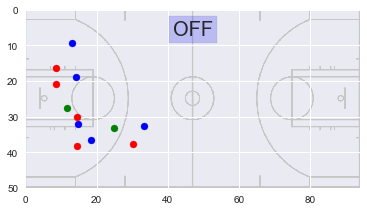

In [7]:
def plotPlay(df, i, suf):
    court = plt.imread("fullcourt.png")
    plt.imshow(court, zorder = 0, extent=[0,94,50,0])
    row = df.iloc[i]
    plt.scatter(row['PLAYER1_XLOC'+suf], row['PLAYER1_YLOC'+suf], c = 'blue')
    plt.scatter(row['PLAYER2_XLOC'+suf], row['PLAYER2_YLOC'+suf], c = 'blue')
    plt.scatter(row['PLAYER3_XLOC'+suf], row['PLAYER3_YLOC'+suf], c = 'blue')
    plt.scatter(row['PLAYER4_XLOC'+suf], row['PLAYER4_YLOC'+suf], c = 'blue')
    plt.scatter(row['PLAYER5_XLOC'+suf], row['PLAYER5_YLOC'+suf], c = 'blue')

    plt.scatter(row['PLAYER6_XLOC'+suf], row['PLAYER6_YLOC'+suf], c = 'red')
    plt.scatter(row['PLAYER7_XLOC'+suf], row['PLAYER7_YLOC'+suf], c = 'red')
    plt.scatter(row['PLAYER8_XLOC'+suf], row['PLAYER8_YLOC'+suf], c = 'red')
    plt.scatter(row['PLAYER9_XLOC'+suf], row['PLAYER9_YLOC'+suf], c = 'red')
    plt.scatter(row['PLAYER10_XLOC'+suf], row['PLAYER10_YLOC'+suf], c = 'red')

    plt.scatter(row['BALL_XLOC_UP'], row['BALL_YLOC_UP'], c = 'green')
#     plt.scatter(row['BALL_XLOC_PEAK'], row['BALL_YLOC_PEAK'], c = 'green')
    plt.scatter(row['BALL_XLOC_FALL'], row['BALL_YLOC_FALL'], c = 'green')
    
    if row['OFFENSIVE_REB_FALL'] == 1:
        txt = 'OFF'
        col = 'blue'
    else:
        txt = 'DEF'
        col = 'red'
    plt.text(47, 7, txt, fontsize=20, horizontalalignment='center',
             bbox=dict(facecolor=col, alpha=0.2))
    
n = 115
plotPlay(df, n, '_FALL')

In [39]:
from imblearn.over_sampling import RandomOverSampler

X = outdf.drop('Off_Reb', axis = 1)
y = outdf['Off_Reb']

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=0)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0)
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
print(model2.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, predicted))

0.862980280545
[[3888  172]
 [ 502  357]]


In [32]:
# Cross-validation
t0 = time.time()
scores = cross_val_score(GradientBoostingClassifier(n_estimators=100,
                                                    learning_rate=1.0,
                                                    max_depth=1,
                                                    random_state=0),
                         X_resampled, y_resampled, scoring='accuracy', cv=10)
print(scores.mean())
t1 = time.time()
print(t1 - t0)

0.599900211092
8.290473937988281
